# Advanced sktime features

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Time-series transformers

Tranformers in `sktime` referr to a catch-all term that encompses modular data processing steps.

### Manual tranformations: doing things the wrong way

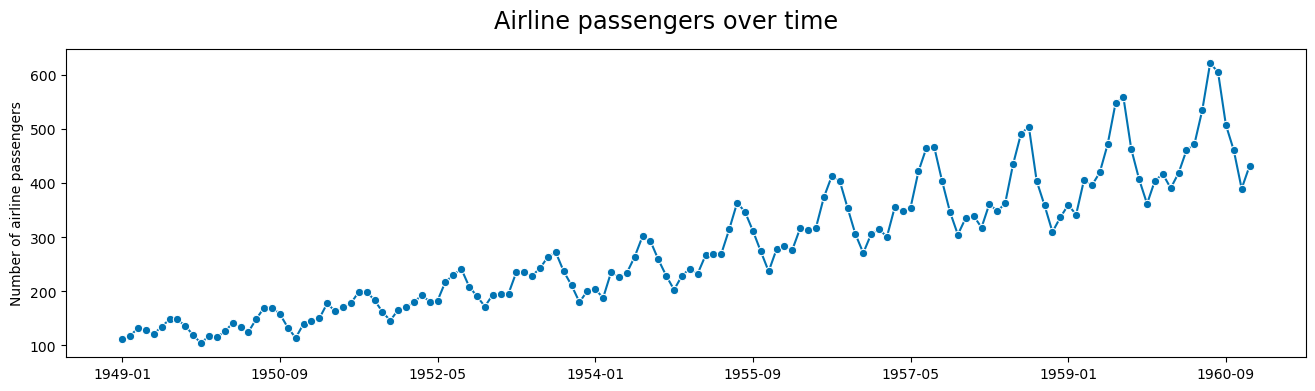

In [3]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()

fig, ax = plot_series(y, title="Airline passengers over time")

We visually see a yearly seasonality in the data that increases with an increasing number of passengers. Maybe we can remove this by taking the log of the data.

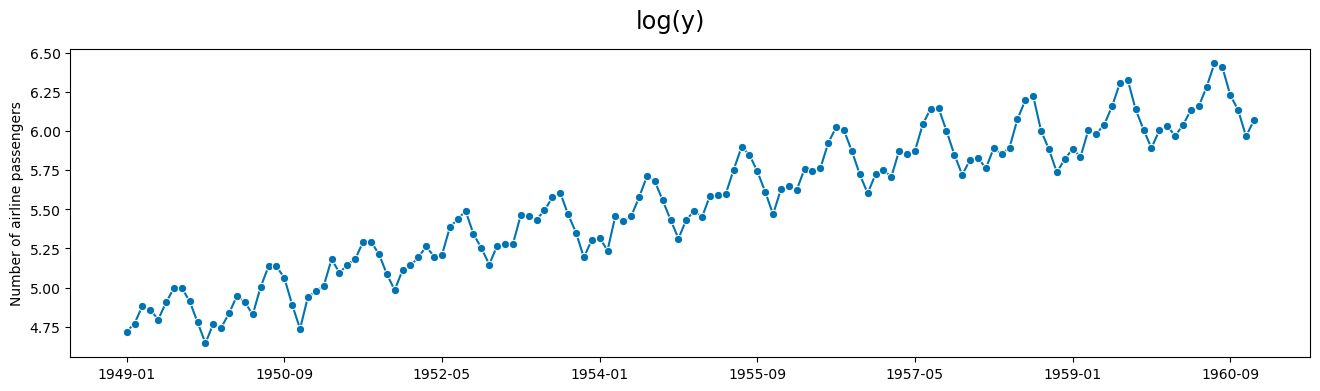

In [4]:
import numpy as np

y_log = np.log(y)

fig, ax = plot_series(y_log, title="log(y)")

Now the seasonality patterns looks constant over time, so we can decompose `log(y)` and then we can remove it.

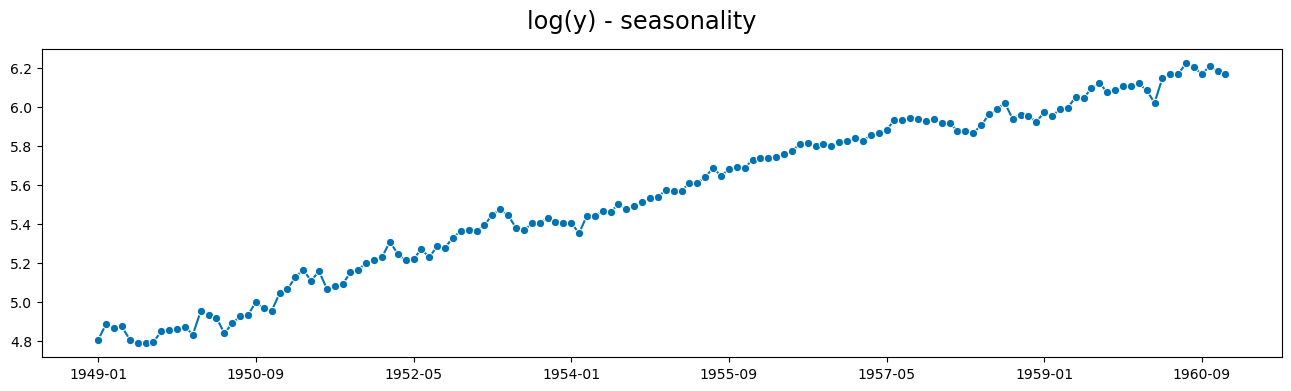

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_result = seasonal_decompose(y_log, period=12)
seasonal = seasonal_result.seasonal
y_log_deseasonalised = y_log - seasonal

fig, ax = plot_series(y_log_deseasonalised, title="log(y) - seasonality")

We can now forecast the log and deseasonalized data and then reverse the transformations to get back to the original scale.

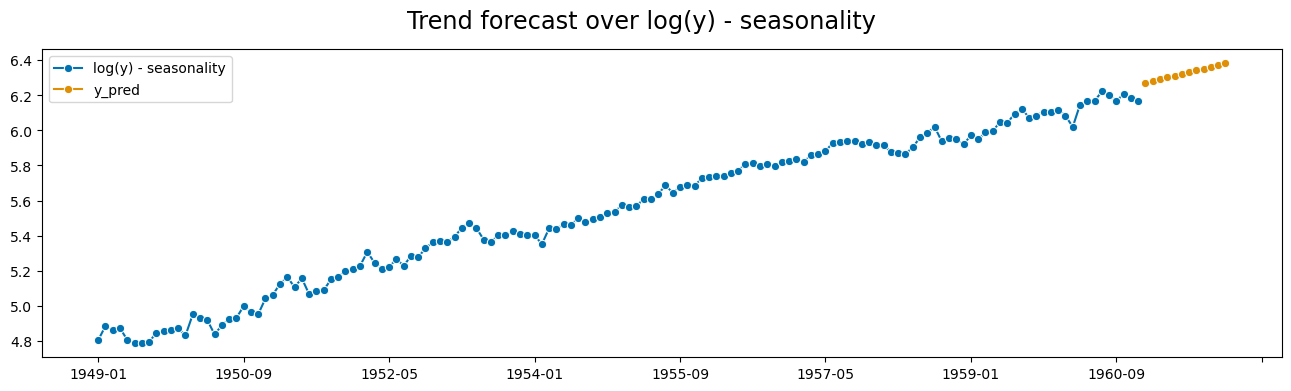

In [6]:
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()
y_pred = forecaster.fit_predict(y_log_deseasonalised, fh=list(range(1, 13)))

fig, ax = plot_series(
    y_log_deseasonalised,
    y_pred,
    labels=["log(y) - seasonality", "y_pred"],
    title="Trend forecast over log(y) - seasonality",
)

Looks reasonable! Now we have to turn this into a forecast of the original data by:
- Add back the seasonality
- Invert the logarithm

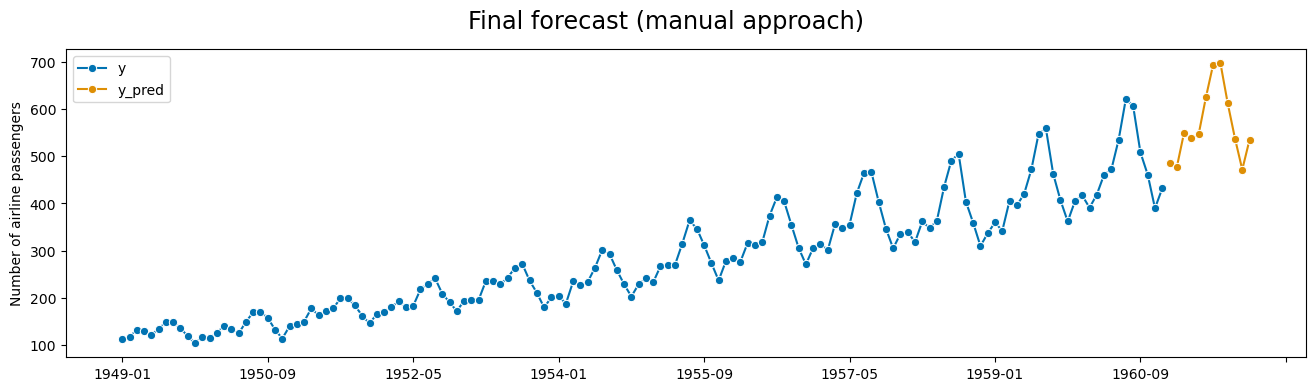

In [7]:
y_pred_add_seasonality = y_pred + seasonal[0:12].values
y_pred_orig = np.exp(y_pred_add_seasonality)

fig, ax = plot_series(y, y_pred_orig, labels=["y", "y_pred"], title="Final forecast (manual approach)")

Ok, done! And it only took us 10 years...

### `sktime` transformers: doing things the right way

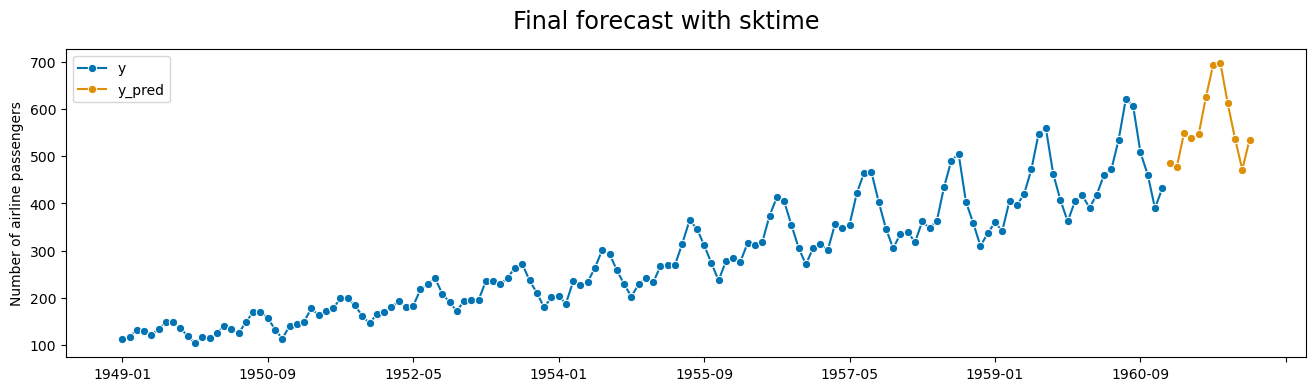

In [8]:
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

forecaster = LogTransformer() * Deseasonalizer(sp=12) * TrendForecaster()

y_pred = forecaster.fit_predict(y, fh=list(range(1, 13)))

fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"], title="Final forecast with sktime")

Let's break this down, what happened here?

The "chain" operator `*` creates a "forecasting pipeline". The pipeline is a sequence of steps that are applied to the data in order. The final forecaster has the same interface as all other forecasters, so we can use it directly without having to manually apply the transformations. More about pipelines later.

The log and deseasonalization transformations are implemented as `sktime` transformers. A transformer is a data processing step that can be applied to a time series. It has a `fit` and `transform` method. The transformations above are invertible, and this is used by the forecasting pipeline to invert the transformations when forecasting.

### Transformer type glossary,

Common types of transformation in `sktime`:

| from | to | base class | examples (sci) | examples (`sktime`) |
| --- | --- | --- | --- | --- |
| time series | scalar features | `BaseTransformer` (`Primitives` output) | `tsfresh`, or 7-number-summary | `Catch22`,`SummaryTransformer` |
| time series | time series | `BaseTransformer` (`Series`, `instancewise`)  | detrending, smoothing, filtering, lagging | `Detrender`,`Differencer`, `Lag`, `Filter` |
| time series panel | also a panel | `BaseTransformer` (`Series` output)  | principal component projection | `PCATransformer`,`PaddingTransformer` |
| two feature vectors | a scalar | `BasePairwiseTransformer` | Euclidean distance, L1 distance | `ScipyDist`, `AggrDist`, `FlatDist` |
| two time series | a scalar | `BasePairwiseTransformerPanel` | DTW distance, alignment kernel | `DtwDist`, `EditDist` |

To illustrate the difference, we compare two transformers with different output:

- The Box-Cox transformer `BoxCoxTrannsformer`, which transforms a time series to a time series
- The summary transformer `SummaryTransformer`, which transforms a time series to descriptive scalars (e.g. mean, standard deviation, etc.)

In [9]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.summarize import SummaryTransformer

y = load_airline()

boxcox = BoxCoxTransformer()
summary = SummaryTransformer()

In [10]:
# BoxCoxTransformer() produces a pd.Series
boxcox.fit_transform(y)

Period
1949-01     6.827490
1949-02     6.932822
1949-03     7.161892
1949-04     7.114611
1949-05     6.983787
             ...    
1960-08    10.684049
1960-09    10.234573
1960-10     9.992159
1960-11     9.582623
1960-12     9.831860
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [11]:
# SummaryTransformer() produces a (set of) scalar (values)
summary.fit_transform(y)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,280.298611,119.966317,104.0,622.0,135.3,180.0,265.5,360.5,453.2


In [12]:
from sktime.registry import all_estimators

# now subset to transformers that extract scalar features
all_estimators(
    "transformer",
    as_dataframe=True,
    filter_tags={"scitype:transform-output": "Series"},
    suppress_import_stdout=False,
)

,name,estimator
0,Aggregator,<class 'sktime.transformations.hierarchical.ag...
1,AutoCorrelationTransformer,<class 'sktime.transformations.series.acf.Auto...
2,BKFilter,<class 'sktime.transformations.series.bkfilter...
3,BoxCoxTransformer,<class 'sktime.transformations.series.boxcox.B...
4,CFFilter,<class 'sktime.transformations.series.cffilter...
...,...,...
77,TransformerPipeline,<class 'sktime.transformations.compose._pipeli...
78,TruncationTransformer,<class 'sktime.transformations.panel.truncatio...
79,WhiteNoiseAugmenter,<class 'sktime.transformations.series.augmente...
80,WindowSummarizer,<class 'sktime.transformations.series.summariz...


Like forecasters, transformers are automatically vectorized (upcaster) to handle hierarchical (and/or multivariate) time series.

In [13]:
from sktime.utils._testing.hierarchical import _make_hierarchical

# Make a multivariate hierarchical time series
y_hier_multi = _make_hierarchical(n_columns=2)

y_hier_multi

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  3.459628  4.571781
          2000-01-02  4.929518  5.236811
          2000-01-03  5.232745  2.633909
          2000-01-04  3.749636  2.508916
          2000-01-05  3.980888  2.461733
...                        ...       ...
h0_1 h1_3 2000-01-08  2.691797  4.705391
          2000-01-09  4.937947  1.692956
          2000-01-10  6.124661  4.998856
          2000-01-11  3.443110  4.664187
          2000-01-12  4.316948  2.696300

[96 rows x 2 columns]

In [14]:
boxcox = BoxCoxTransformer(method="mle")
boxcox.fit_transform(y_hier_multi)

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  0.738420  1.671272
          2000-01-02  0.834321  1.836378
          2000-01-03  0.847618  1.028518
          2000-01-04  0.763056  0.973912
          2000-01-05  0.780220  0.952677
...                        ...       ...
h0_1 h1_3 2000-01-08  1.348599  4.654212
          2000-01-09  2.665394  0.740776
          2000-01-10  3.259461  5.076888
          2000-01-11  1.826354  4.595344
          2000-01-12  2.331440  1.942014

[96 rows x 2 columns]

In [15]:
boxcox.transformers_

1                           c0                   c1
h0_0 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()
h0_1 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()

## Pipelines and feature engineering

We can build pipelines with `sktime` transformers and forecasters. Pipelines are a sequence of steps that are applied to the data in order. For forecasting pipelines, the final forecaster has the same interface as all other forecasters, so we can use it directly without having to manually apply the transformations. Same for classification pipelines and also a purely transformer pipeline.

### Dunders glossary - pipeline operators

| Type | Dunder | Meaning | `sktime` class |
| --- | --- | --- | --- |
| compose | `*` | chaining/pipeline - also works with other estimator types | type dependent |
| compose | `**` | chaining to secondary input of another estimator | type dependent |
| compose | `+` | feature union | `FeatureUnion` |
| interface | `~` | invert | `InvertTransform` |
| structural | `¦` | multiplexing (\"switch\") | type dependent |
| structural | `-` | optional passthrough (\"on/off\") | `OptionalPassthrough` |

### Pipelines for forecasting in `sktime`

Let's look at an example we showed earlier.

In [16]:
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

forecaster_pipeline = LogTransformer() * Deseasonalizer(sp=12) * TrendForecaster()

forecaster_pipeline

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   TrendForecaster()])

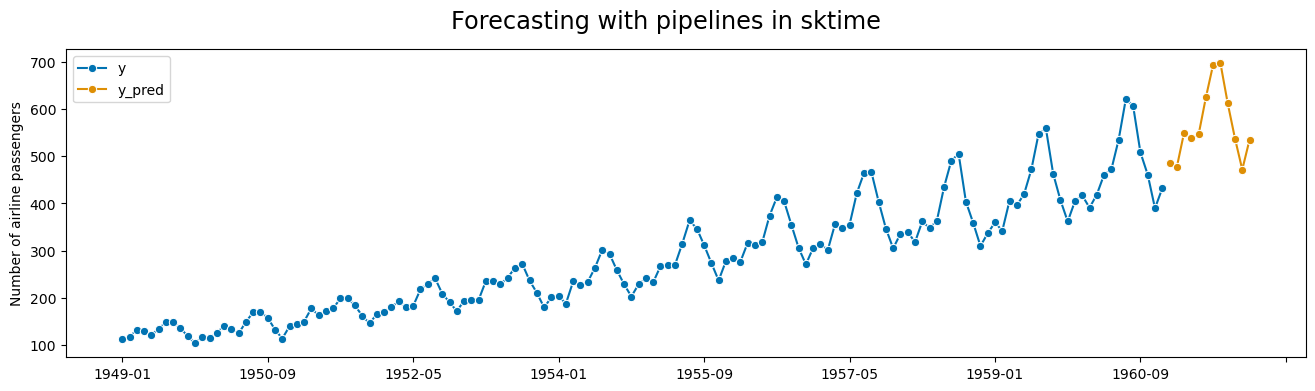

In [17]:
y_pred = forecaster_pipeline.fit_predict(y, fh=list(range(1, 13)))

fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"], title="Forecasting with pipelines in sktime")

### Pipelines for classification in `sktime`

In [18]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.transformations.series.exponent import ExponentTransformer

classifier_pipeline = ExponentTransformer() * KNeighborsTimeSeriesClassifier()

classifier_pipeline

ClassifierPipeline(classifier=KNeighborsTimeSeriesClassifier(),
                   transformers=[ExponentTransformer()])

In [19]:
import pandas as pd
from sktime.datasets import load_unit_test

X_train, y_train = load_unit_test(split="TRAIN")
X_test, _ = load_unit_test(split="TEST")

pd.concat([X_train, pd.Series(y_train)], axis=1).rename(columns={0: "Class label"})

,dim_0,Class label
0,0 573.0 1 375.0 2 301.0 3 ...,1
1,0 394.0 1 264.0 2 140.0 3 ...,1
2,0 603.0 1 348.0 2 176.0 3 ...,1
3,0 428.0 1 309.0 2 199.0 3 ...,1
4,0 372.0 1 310.0 2 203.0 3 ...,1
5,0 448.0 1 344.0 2 183.0 3 ...,1
6,0 621.0 1 322.0 2 221.0 3 ...,1
7,0 597.0 1 409.0 2 142.0 3 ...,1
8,0 525.0 1 431.0 2 248.0 3 ...,1
9,0 587.0 1 382.0 2 165.0 3 ...,1


In [20]:
classifier_pipeline.fit(X_train, y_train)

ClassifierPipeline(classifier=KNeighborsTimeSeriesClassifier(),
                   transformers=[ExponentTransformer()])

In [21]:
y_pred = classifier_pipeline.predict(X_test)
pd.concat([X_test, pd.Series(y_pred)], axis=1).rename(columns={0: "Predicted class label"})

,dim_0,Predicted class label
0,0 501.0 1 328.0 2 195.0 3 ...,1
1,0 880.0 1 752.0 2 913.0 3 ...,1
2,0 493.0 1 389.0 2 174.0 3 ...,1
3,0 616.0 1 323.0 2 162.0 3 ...,1
4,0 389.0 1 276.0 2 161.0 3 ...,1
5,0 548.0 1 384.0 2 245.0 3 ...,1
6,0 369.0 1 297.0 2 171.0 3 ...,1
7,0 418.0 1 350.0 2 116.0 3 ...,1
8,0 504.0 1 273.0 2 175.0 3 ...,1
9,0 498.0 1 339.0 2 170.0 3 ...,1


### Combining transformers

#### Sequential combination with `*`

Showed previously, but let's look at it again using sklearn transformers.

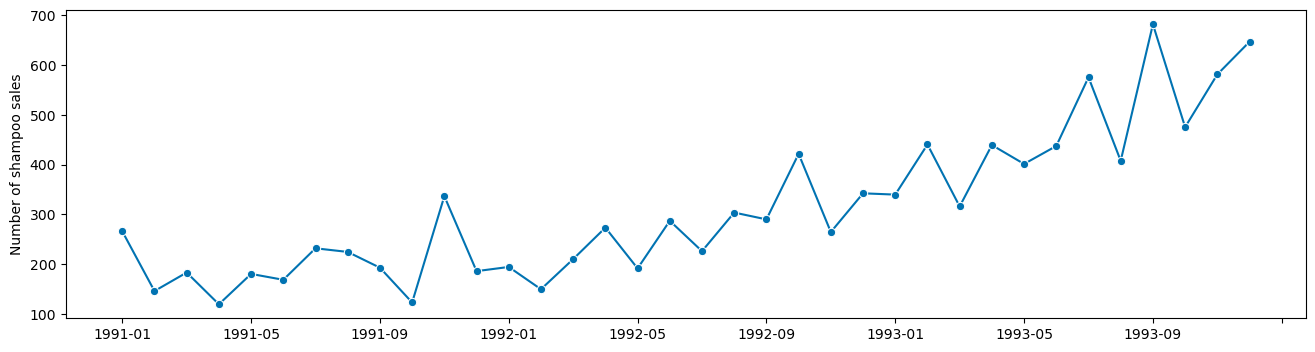

In [22]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

fig, ax = plot_series(y)

In [23]:
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.difference import Differencer

sequence_pipeline = Differencer() * StandardScaler()

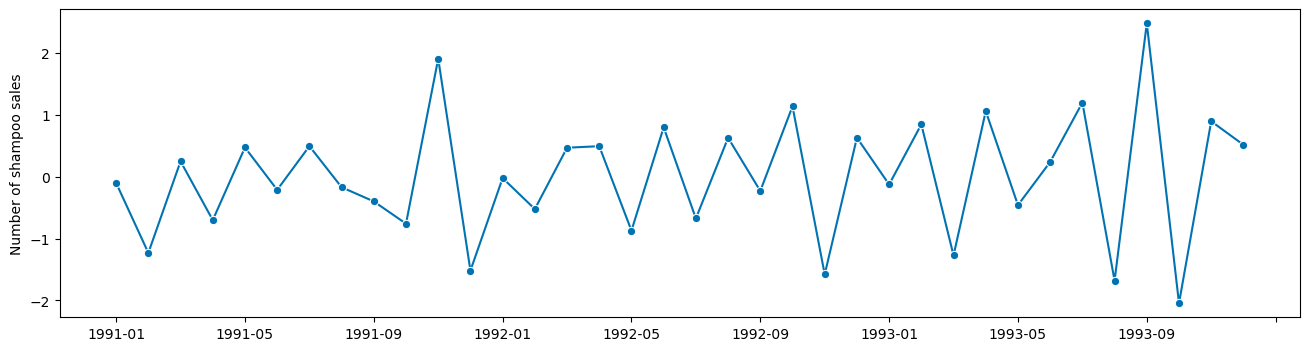

In [24]:
y_transformed = sequence_pipeline.fit_transform(y)
fig, ax = plot_series(y_transformed)

In [25]:
sequence_pipeline.get_params()

{'steps': [Differencer(),
  TabularToSeriesAdaptor(transformer=StandardScaler())],
 'Differencer': Differencer(),
 'TabularToSeriesAdaptor': TabularToSeriesAdaptor(transformer=StandardScaler()),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'TabularToSeriesAdaptor__fit_in_transform': False,
 'TabularToSeriesAdaptor__transformer__copy': True,
 'TabularToSeriesAdaptor__transformer__with_mean': True,
 'TabularToSeriesAdaptor__transformer__with_std': True,
 'TabularToSeriesAdaptor__transformer': StandardScaler()}

#### Union combination with `+`

In [26]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

union_pipeline = Differencer() + Lag(1) + Lag(2)

union_pipeline

FeatureUnion(transformer_list=[Differencer(), Lag(lags=1), Lag(lags=2)])

In [27]:
union_pipeline.fit_transform(y).head()

,Differencer__Number of shampoo sales,Lag_1__lag_1__Number of shampoo sales,Lag_2__lag_2__Number of shampoo sales
1991-01,0.0,NaN,NaN
1991-02,-120.1,266.0,NaN
1991-03,37.2,145.9,266.0
1991-04,-63.8,183.1,145.9
1991-05,61.0,119.3,183.1


You can keeep the original signal using the `Id()` (identity) transformer.

In [28]:
from sktime.transformations.compose import Id
# Note we can combine two lag transformers into one
union_pipeline = Id() + Differencer() + Lag([1, 2], index_out="original")

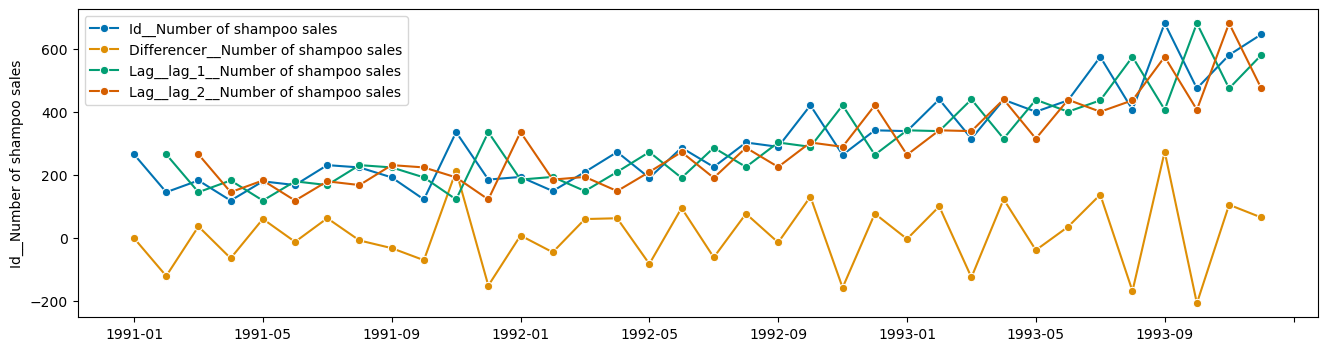

In [29]:
y_transformed = union_pipeline.fit_transform(y)

fig, ax = plot_series(*(y_transformed[col] for col in y_transformed.columns), labels=y_transformed.columns)

### Apply transformation to individual series

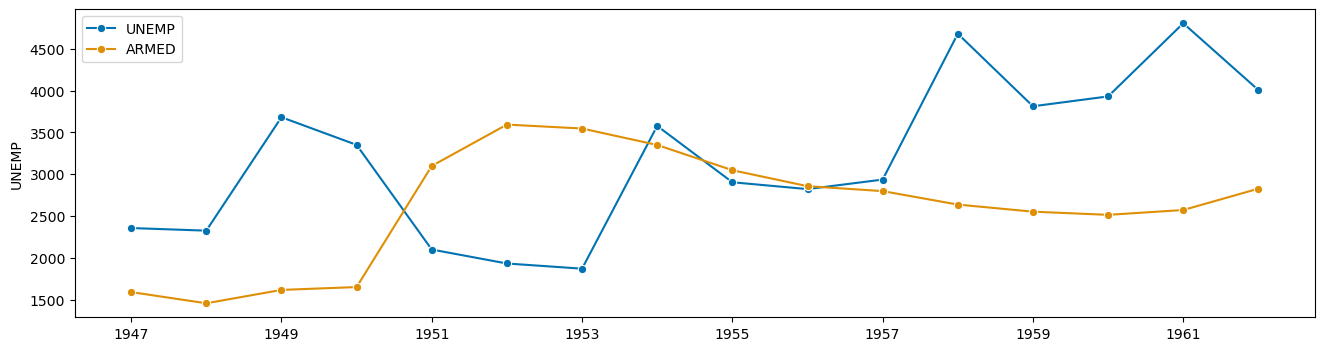

In [30]:
from sktime.datasets import load_longley

_, y = load_longley()

y = y.iloc[:, 2:4]

fig, ax = plot_series(*(y[col] for col in y.columns), labels=y.columns)

Let's apply a lag of 1 to tthe first time series and a lag of 6 to second one.

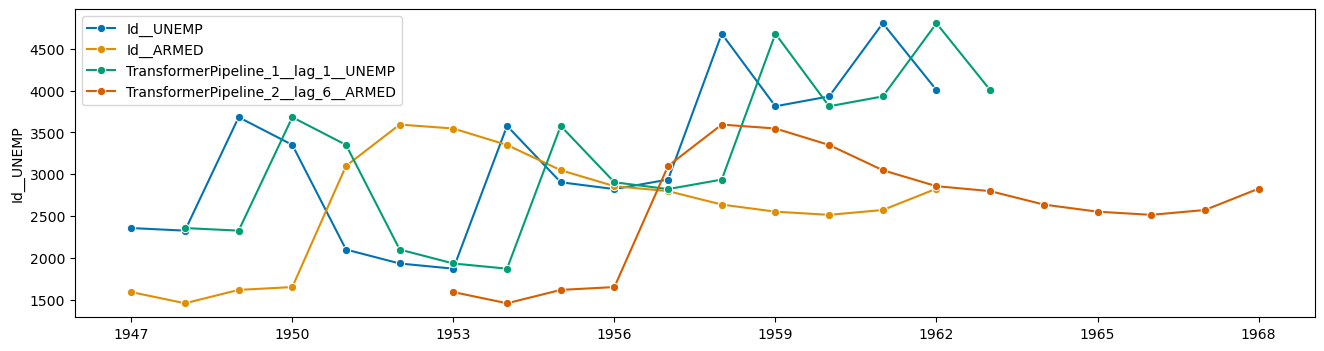

In [31]:
individual_pipeline = Id() + Lag(1)["UNEMP"] + Lag(6)["ARMED"]

y_transformed = individual_pipeline.fit_transform(y)

fig, ax = plot_series(*(y_transformed[col] for col in y_transformed.columns), labels=y_transformed.columns)

But the default names are kind of ugly, let's rename them in the pipeline constructor.

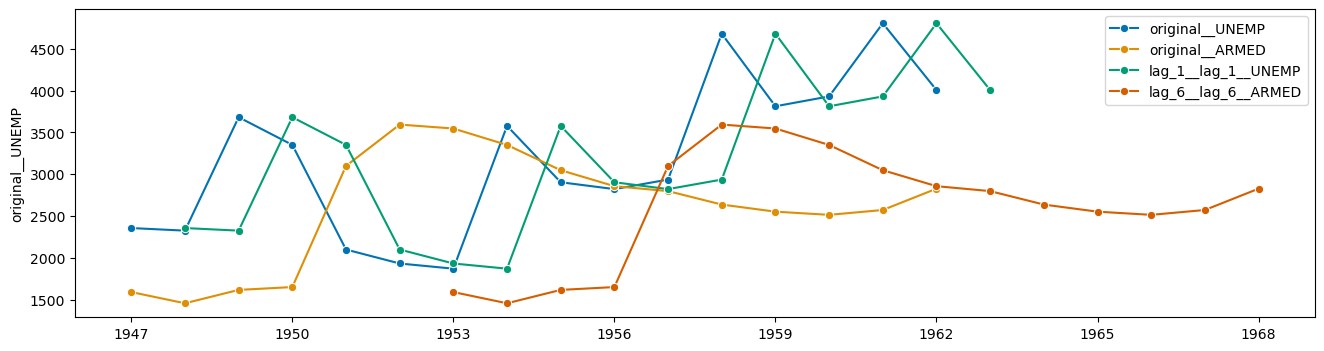

In [32]:
from sktime.transformations.compose import FeatureUnion

better_names_pipeline = FeatureUnion(
    [
        ("original", Id()),
        ("lag_1", Lag(1)["UNEMP"]),
        ("lag_6", Lag(6)["ARMED"]),
    ]
)

y_transformed = better_names_pipeline.fit_transform(y)

fig, ax = plot_series(*(y_transformed[col] for col in y_transformed.columns), labels=y_transformed.columns)

### Invert transformations with `~`

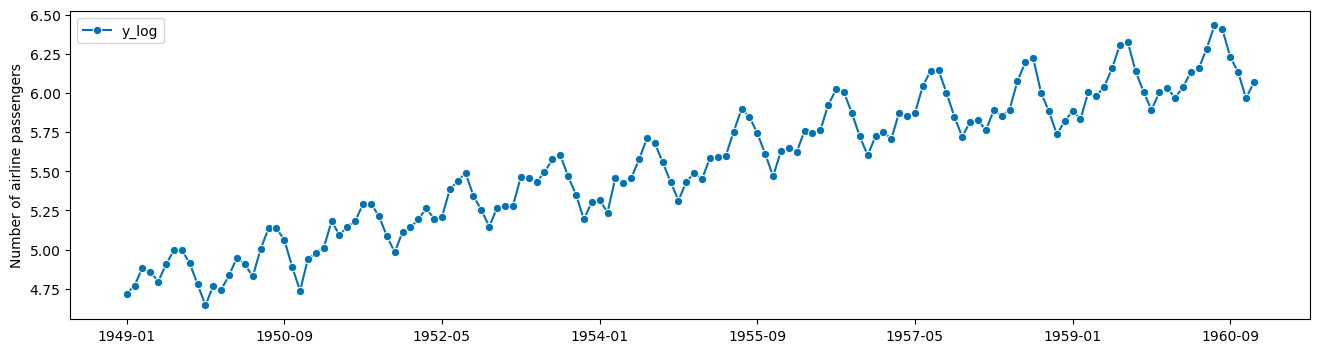

In [41]:
from sktime.transformations.series.boxcox import LogTransformer

y = load_airline()

log_pipeline = LogTransformer()

y_log = log_pipeline.fit_transform(y)

fig, ax = plot_series(y_log, labels=["y_log"])

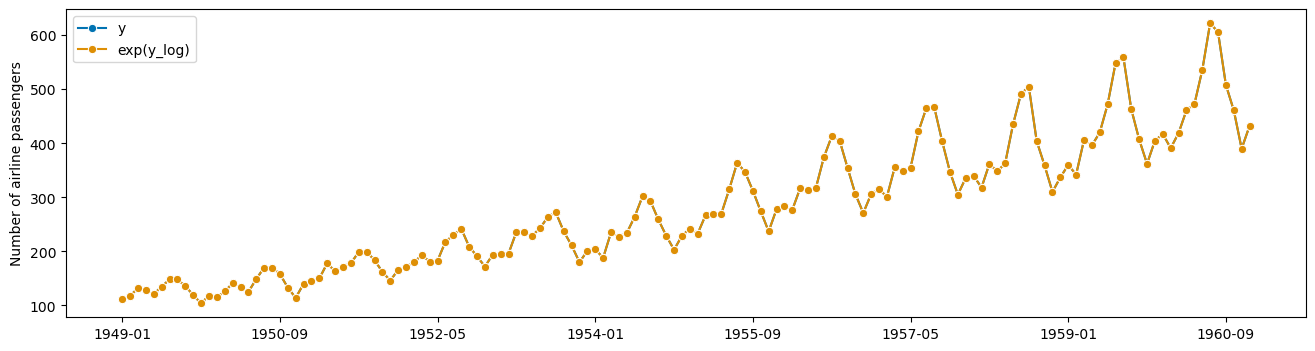

In [42]:
exp_pipeline = ~LogTransformer()

y_orig = exp_pipeline.fit_transform(y_log)

fig, ax = plot_series(y, y_orig, labels=["y", "exp(y_log)"])

### Multiplexing with `¦`

We can contruct a switchable pipeline where we can choose between two different transformations. In this case we can compare deseasonalizing and detrending vs a box-cox transformation.

In [51]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.detrend import Detrender

pipe = BoxCoxTransformer() | (
    Deseasonalizer(sp=12, model="multiplicative") * Detrender(model="multiplicative")
)

pipe.get_params()

{'selected_transformer': None,
 'transformers': [BoxCoxTransformer(),
  TransformerPipeline(steps=[Deseasonalizer(model='multiplicative', sp=12),
                             Detrender(model='multiplicative')])],
 'BoxCoxTransformer': BoxCoxTransformer(),
 'TransformerPipeline': TransformerPipeline(steps=[Deseasonalizer(model='multiplicative', sp=12),
                            Detrender(model='multiplicative')]),
 'BoxCoxTransformer__bounds': None,
 'BoxCoxTransformer__method': 'mle',
 'BoxCoxTransformer__sp': None,
 'TransformerPipeline__steps': [Deseasonalizer(model='multiplicative', sp=12),
  Detrender(model='multiplicative')],
 'TransformerPipeline__Deseasonalizer': Deseasonalizer(model='multiplicative', sp=12),
 'TransformerPipeline__Detrender': Detrender(model='multiplicative'),
 'TransformerPipeline__Deseasonalizer__model': 'multiplicative',
 'TransformerPipeline__Deseasonalizer__sp': 12,
 'TransformerPipeline__Detrender__forecaster': None,
 'TransformerPipeline__Detrender__mo

In [52]:
pipe.set_params(selected_transformer="BoxCoxTransformer").get_params()

{'selected_transformer': 'BoxCoxTransformer',
 'transformers': [BoxCoxTransformer(),
  TransformerPipeline(steps=[Deseasonalizer(model='multiplicative', sp=12),
                             Detrender(model='multiplicative')])],
 'BoxCoxTransformer': BoxCoxTransformer(),
 'TransformerPipeline': TransformerPipeline(steps=[Deseasonalizer(model='multiplicative', sp=12),
                            Detrender(model='multiplicative')]),
 'BoxCoxTransformer__bounds': None,
 'BoxCoxTransformer__method': 'mle',
 'BoxCoxTransformer__sp': None,
 'TransformerPipeline__steps': [Deseasonalizer(model='multiplicative', sp=12),
  Detrender(model='multiplicative')],
 'TransformerPipeline__Deseasonalizer': Deseasonalizer(model='multiplicative', sp=12),
 'TransformerPipeline__Detrender': Detrender(model='multiplicative'),
 'TransformerPipeline__Deseasonalizer__model': 'multiplicative',
 'TransformerPipeline__Deseasonalizer__sp': 12,
 'TransformerPipeline__Detrender__forecaster': None,
 'TransformerPipeline

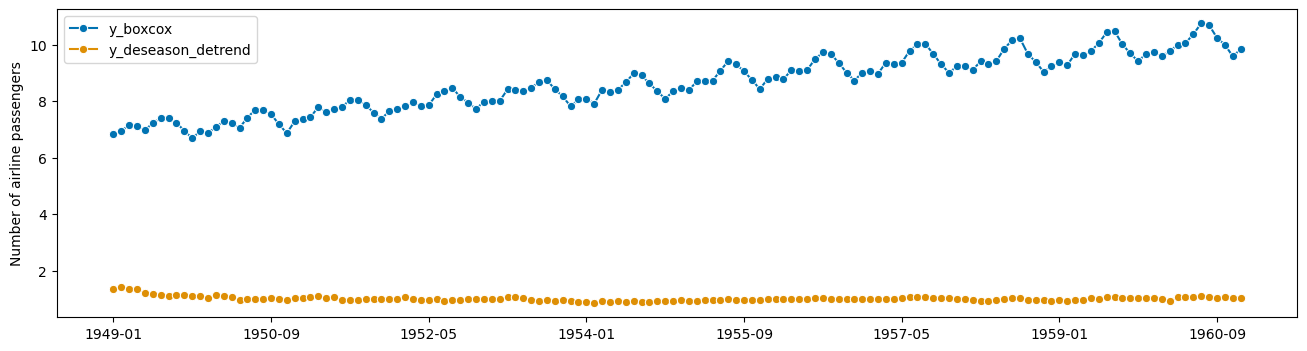

In [53]:
y = load_airline()

y_boxcox = pipe.set_params(selected_transformer="BoxCoxTransformer").fit_transform(y)
y_log_deseason_detrend = pipe.set_params(selected_transformer="TransformerPipeline").fit_transform(y)

fig, ax = plot_series(y_boxcox, y_log_deseason_detrend, labels=["y_boxcox", "y_deseason_detrend"])

### On-off switch: optional passthrough with `-`

In [54]:
optional_differencer = -Differencer()

optional_differencer

OptionalPassthrough(transformer=Differencer())

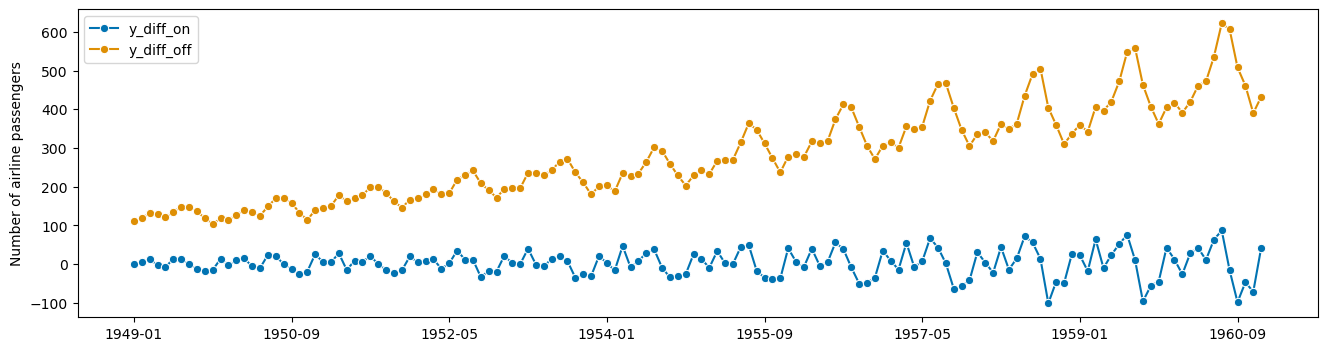

In [55]:
y = load_airline()

y_diff_on = optional_differencer.fit_transform(y)
y_diff_off = optional_differencer.set_params(passthrough=True).fit_transform(y)

fig, ax = plot_series(y_diff_on, y_diff_off, labels=["y_diff_on", "y_diff_off"])

## Pipelines in action: AutoML with `sktime`

WIP

In [ ]:
pipe_y = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", STLForecaster()),
    ]
)
permuted_y = Permute(estimator=pipe_y, permutation=None)

param_grid = {
    "permutation": [
        ["detrender", "deseasonalizer", "scaler", "forecaster"],
        ["scaler", "deseasonalizer", "detrender", "forecaster"],
    ],
    "estimator__detrender__passthrough": [True, False],
    "estimator__deseasonalizer__passthrough": [True, False],
    "estimator__scaler__passthrough": [True, False],
    "estimator__scaler__transformer__transformer__with_scaling": [True, False],
    "estimator__scaler__transformer__transformer__with_centering": [True, False],
    "estimator__forecaster__sp": [4, 8, 12],
}

gscv = ForecastingGridSearchCV(
    forecaster=permuted_y,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
    error_score="raise",
)

gscv.fit(y=y_train, fh=fh)

## Deployment